In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/UROP_Lee/"
%ls
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Mounted at /content/drive
/content/drive/My Drive/UROP_Lee
 11_3_15_06.csv      Machine_training.ipynb         Test2.csv       Testing4.csv
 11_3_15_06_pw.csv   Measured.csv                   Test3.csv       Train.csv
 11_3_15_17.csv     'New data'/                     Test4.csv       Train_data.csv
 11_3_15_17_pw.csv   Power_machine_learning.ipynb   Test_data.csv   Train_feature.txt
 3_11_15_07.csv      Predicted_value.csv            Testing1.csv
 3_12_15_06.csv      Target_value.csv               Testing2.csv
 best_model.h5       Test1.csv                      Testing3.csv


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LeakyReLU,LSTM,Bidirectional, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L1L2
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow.keras.backend as K

In [ ]:
class Read_file:
    def __init__(self, path):
        self.path = path
        self.data_frame = self.read_from_path()

    def read_from_path(self):
        return pd.read_csv(self.path)

    def get_data(self, smoothness=None):
        if smoothness is None:
            return self.data_frame
        else:
            smooth_data_frame = self.data_frame.copy()
            smooth_data_frame['watt'] = self.data_frame['watt'].rolling(window=smoothness, min_periods=1).mean()
            return smooth_data_frame


    def get_shuffled_data(self, smoothness=None):
        if smoothness is None:
            return self.data_frame.sample(frac=1).reset_index(drop=True)
        else:
            smooth_data_frame = self.data_frame.copy()
            smooth_data_frame['watt'] = self.data_frame['watt'].rolling(window=smoothness, min_periods=1).mean()
            return smooth_data_frame.sample(frac=1).reset_index(drop=True)

In [ ]:
ReadTrain = Read_file('Train.csv')

In [ ]:
def Temperature_feature(df):
  temperature_columns = [col for col in df.columns if '[°C]' in col and col != 'Ambient [°C]']

  # Divide each "xxx Temperature" by "ambient temperature"
  for col in temperature_columns:
      df[col] = (df[col] - df['Ambient [°C]'])/(df['Ambient [°C]'])
      print('updated', col)

  # Now df has the updated values
  return df

a = ReadTrain.get_data(smoothness = 31)

In [ ]:
Test1 = pd.read_csv('/content/drive/My Drive/UROP_Lee/Test1.csv')
Test1.columns = Test1.columns.str.replace('Â', '')
Test2 = pd.read_csv('/content/drive/My Drive/UROP_Lee/Test2.csv')
Test2.columns = Test2.columns.str.replace('Â', '')
Test3 = pd.read_csv('/content/drive/My Drive/UROP_Lee/Test3.csv')
Test3.columns = Test3.columns.str.replace('Â', '')
Test4 = pd.read_csv('/content/drive/My Drive/UROP_Lee/Test4.csv')
Test4.columns = Test4.columns.str.replace('Â', '')

In [ ]:
def drop_non_float_features(dataset):
    non_float_columns = [feature for feature in dataset.columns if dataset[feature].dtype != 'float64']
    # Drop non-float64 columns
    dataset = dataset.drop(non_float_columns, axis=1)
    return dataset

def scale_datasets(base_dataset, test_datasets):
    # Concatenate all datasets along the rows
    combined_dataset = pd.concat([base_dataset] + test_datasets, ignore_index=True)

    # Create a MinMaxScaler object
    combined_dataset = drop_non_float_features(combined_dataset)

    #Fit the thing with the temperature standardization
    combined_dataset = Temperature_feature(combined_dataset)

    # Preserve the 'watt' column
    watt_col = combined_dataset['watt']
    combined_dataset = combined_dataset.drop('watt', axis=1)

    # creating the scaler
    scaler = StandardScaler()

    # scaling the features
    scaled_features = scaler.fit_transform(combined_dataset)

    # converting the scaled features into a DataFrame
    scaled_combined = pd.DataFrame(scaled_features, columns=combined_dataset.columns)

    # returning the 'watt' column
    scaled_combined['watt'] = watt_col.values

    # Separate the scaled data back into the original datasets
    start_idx = 0
    scaled_datasets = []
    for dataset in [base_dataset] + test_datasets:
        end_idx = start_idx + len(dataset)
        # Slice the scaled combined dataset to get the scaled version of the current dataset
        scaled_datasets.append(scaled_combined.iloc[start_idx:end_idx].reset_index(drop=True))
        start_idx = end_idx

    return scaled_datasets

# Usage:
# Assuming 'a' is your base dataset and 'test1', 'test2', 'test3', 'test4' are your test datasets
scaled_datasets = scale_datasets(a, [Test1, Test2, Test3, Test4])

updated Core Temperatures (avg) [°C]
updated Core 0 [°C]
updated Core 1 [°C]
updated Core 2 [°C]
updated Core 3 [°C]
updated Core Distance to TjMAX (avg) [°C]
updated Core 0 Distance to TjMAX [°C]
updated Core 1 Distance to TjMAX [°C]
updated Core 2 Distance to TjMAX [°C]
updated Core 3 Distance to TjMAX [°C]
updated CPU Package [°C]
updated Core Max [°C]
updated CPU Package [°C].1
updated CPU IA Cores [°C]
updated CPU GT Cores (Graphics) [°C]
updated VR VCC Temperature (SVID) [°C]
updated PCH Temperature [°C]
updated CPU [°C]
updated Drive Temperature [°C]
updated GPU Thermal Diode [°C]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
a = scaled_datasets[0]
Test1 = scaled_datasets[1]
Test2 = scaled_datasets[2]
Test3 = scaled_datasets[3]
Test4 = scaled_datasets[4]

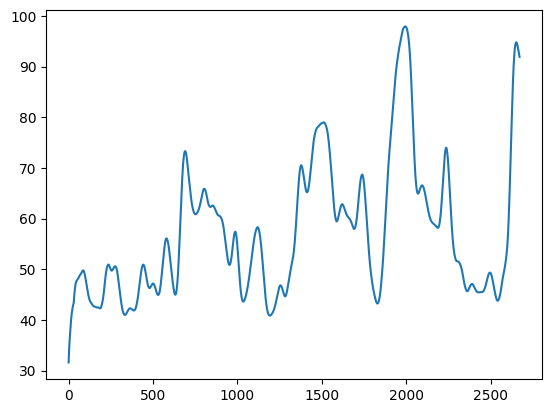

In [ ]:
series_to_plot = a['watt']
series_to_plot.plot(kind='line')  # you can change 'line' to 'bar', 'hist' etc.

plt.show()

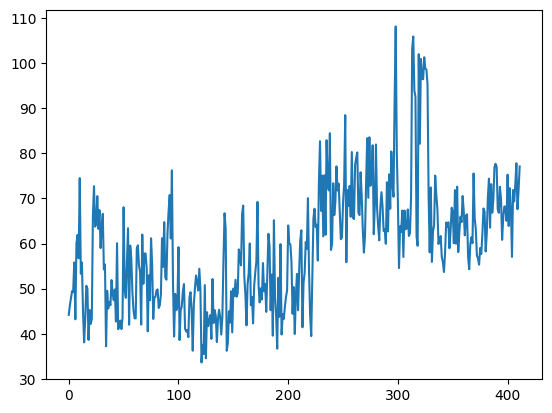

In [ ]:
series_to_plot = Test1['watt']
series_to_plot.plot(kind='line')  # you can change 'line' to 'bar', 'hist' etc.

plt.show()

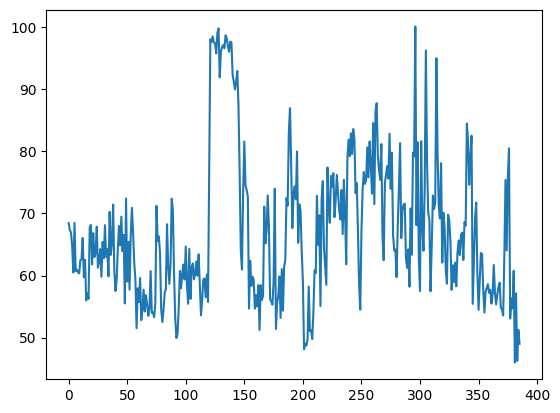

In [ ]:
series_to_plot = Test2['watt']
series_to_plot.plot(kind='line')  # you can change 'line' to 'bar', 'hist' etc.

plt.show()

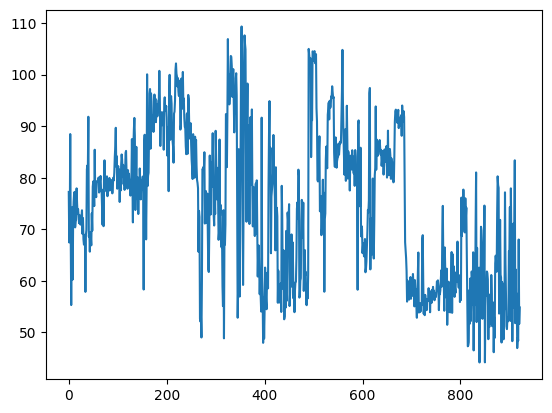

In [ ]:
series_to_plot = Test3['watt']
series_to_plot.plot(kind='line')  # you can change 'line' to 'bar', 'hist' etc.

plt.show()

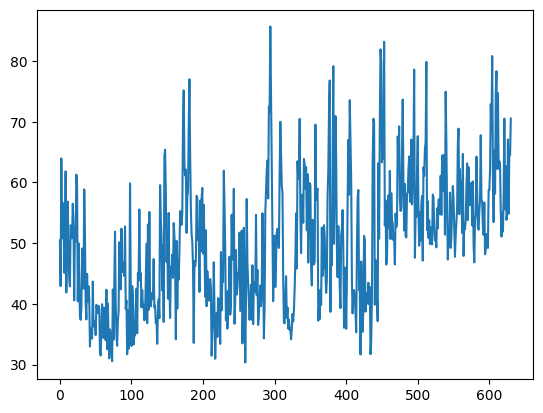

In [ ]:
series_to_plot = Test4['watt']
series_to_plot.plot(kind='line')  # you can change 'line' to 'bar', 'hist' etc.

plt.show()

Drop duplicates

Select best numerical features

In [ ]:
def selectKbest(Train_data_df, k):
  X = Train_data_df.drop(['watt'], axis=1)  # assuming 'watt' is your target column
  y = Train_data_df['watt']

  # ensure you only take in numerical columns
  X = X.select_dtypes([np.number])
  for column in X.columns:
      if X[column].isnull().any():    # if any value in the column is null
          X = X.drop(column, axis=1) # drop the column
  # Secondly, apply SelectKBest class to extract the top k best features
  bestfeatures = SelectKBest(score_func=f_regression, k=10)  # here k is the number of top features you want to select
  fit = bestfeatures.fit(X,y)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)

  # concatenate two dataframes for better visualization
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  featureScores.columns = ['Features','Score']  # naming the dataframe columns

  # print k best features
  return featureScores.nlargest(k,'Score')

In [ ]:
def select_independent_features(Train_data_df, k=50):
    X = Train_data_df.drop(['watt'], axis=1)  # assuming 'watt' is your target column
    y = Train_data_df['watt']

    # Ensure you only take in numerical columns
    X = X.select_dtypes([np.number])
    X = X.dropna(axis=1)  # Drop columns with any NaN values

    # Calculate the absolute correlation matrix
    corr_matrix = X.corr().abs()

    # Set the diagonal to NaN to ignore self-correlation
    np.fill_diagonal(corr_matrix.values, np.nan)

    # Initialize the list of selected features and their average correlation
    selected_features = []
    average_corr = []

    # Iteratively add features with the lowest average correlation to the selected features
    while len(selected_features) < k:
        remaining_features = corr_matrix.columns.difference(selected_features)
        current_feature = None
        current_feature_corr = 1

        for feature in remaining_features:
            avg_corr = corr_matrix.loc[feature, selected_features].mean() if selected_features else 0
            if avg_corr < current_feature_corr:
                current_feature = feature
                current_feature_corr = avg_corr

        if current_feature is not None:
            selected_features.append(current_feature)
            average_corr.append(current_feature_corr)

    # Create a DataFrame of the selected features and their average correlation
    feature_scores = pd.DataFrame({'Features': selected_features, 'Average Correlation': average_corr})

    return feature_scores

# Usage
# Train_data_df = pd.DataFrame(...)  # Your DataFrame with 'watt' as the target column
# top_50_independent_features = select_independent_features(Train_data_df, 50)
# print(top_50_independent_features)

In [ ]:
f = select_independent_features(a, 50)
Train_feature_list = f['Features'].tolist()  # Convert the selected features to a list
Train_feature_list.append('watt')  # Append 'watt' to the list of selected features

# Create the new DataFrame with only the selected features
f2 = selectKbest(a[Train_feature_list],10)

In [ ]:
Train_feature_list = f2['Features']
for feature in Train_feature_list:
  print(a[feature],feature)

0      -0.556312
1      -0.586942
2      -0.610766
3      -0.508666
4      -0.515472
          ...   
2667   -0.962758
2668   -0.970022
2669   -0.941421
2670   -0.964574
2671   -0.964574
Name: Core 3 [°C], Length: 2672, dtype: float64 Core 3 [°C]
0      -0.606138
1      -0.660433
2      -0.569941
3      -0.620617
4      -0.595279
          ...   
2667   -0.938929
2668   -0.973694
2669   -0.944240
2670   -0.969831
2671   -0.968866
Name: Core 2 [°C], Length: 2672, dtype: float64 Core 2 [°C]
0      -0.595192
1      -0.579471
2      -0.637112
3      -0.623139
4      -0.511350
          ...   
2667   -0.960615
2668   -0.969936
2669   -0.963878
2670   -0.966208
2671   -0.965276
Name: Core 0 [°C], Length: 2672, dtype: float64 Core 0 [°C]
0      -0.854926
1      -0.854926
2      -0.854926
3      -0.854926
4      -0.854926
          ...   
2667   -0.807844
2668   -0.807844
2669   -0.807844
2670   -0.807844
2671   -0.807844
Name: GPU D3D Memory Dynamic [MB].1, Length: 2672, dtype: float64 GPU D3

In [ ]:
with open('Train_feature.txt', 'w') as file:
    for item in Train_feature_list:
        file.write("%s\n" % item)

In [ ]:
Train_feature_list = ['Core Temperatures (avg) [°C]', 'Core Distance to TjMAX (avg) [°C]', 'CPU GT Cores (Graphics) [°C]', 'Core 2 Distance to TjMAX [°C]', 'Core 2 [°C]', 'Core 3 Distance to TjMAX [°C]', 'Core 3 [°C]', 'Core 1 Distance to TjMAX [°C]', 'Core 1 [°C]', 'Core 0 Distance to TjMAX [°C]', 'Core 0 [°C]', 'CPU Package [°C].1', 'VR VCC Temperature (SVID) [°C]', 'CPU IA Cores [°C]', 'Core Max [°C]', 'CPU Package [°C]', 'Core Utility (avg) [%]', 'Total CPU Utility [%]']

# # Make sure to specify the correct path to your file.
# file_path = 'Train_feature.txt'

# # This code opens the file, reads the lines, and stores them in a list.
# try:
#     with open(file_path, 'r') as file:
#         Train_feature_list = [line.strip() for line in file.readlines()]
#     # Now Train_feature_list contains the data from the file
# except FileNotFoundError:
#     print(f"The file at {file_path} was not found.")

print(Train_feature_list)

['Core Temperatures (avg) [°C]', 'Core Distance to TjMAX (avg) [°C]', 'CPU GT Cores (Graphics) [°C]', 'Core 2 Distance to TjMAX [°C]', 'Core 2 [°C]', 'Core 3 Distance to TjMAX [°C]', 'Core 3 [°C]', 'Core 1 Distance to TjMAX [°C]', 'Core 1 [°C]', 'Core 0 Distance to TjMAX [°C]', 'Core 0 [°C]', 'CPU Package [°C].1', 'VR VCC Temperature (SVID) [°C]', 'CPU IA Cores [°C]', 'Core Max [°C]', 'CPU Package [°C]', 'Core Utility (avg) [%]', 'Total CPU Utility [%]']


In [ ]:
def correlation_matrix(data):
    # Assuming df is your DataFrame and train_feature_list is your list of features
  # df = pd.DataFrame(...)  # Your DataFrame
  # train_feature_list = [...]  # Your list of features

  # Calculate the correlation matrix for the features in train_feature_list
  corr_matrix = data[Train_feature_list].corr()

  # We're interested in the absolute values of correlations to find the strongest relationships
  abs_corr_matrix = corr_matrix.abs()

  # Set the diagonal elements to 0 to ignore self-correlation
  np.fill_diagonal(abs_corr_matrix.values, 0)

  # Now, find the top 10 feature pairs with the highest correlation
  # Unstack the correlation matrix to convert it into a Series of feature pairs
  pairs = abs_corr_matrix.unstack()

  # Drop duplicates since correlation(A, B) is the same as correlation(B, A)
  unique_pairs = pairs.drop_duplicates()

  # Sort the pairs by correlation in descending order
  sorted_pairs = pairs.sort_values(ascending=False)

  # Get the pair with the lowest correlation (most independent features)
  lowest_pair = sorted_pairs.head(50)

  print("The most independent feature combination:")
  print(lowest_pair)

correlation_matrix(a[Train_feature_list])

The most independent feature combination:
Core 3 [°C]                    Core 0 [°C]                      0.975433
Core 0 [°C]                    Core 3 [°C]                      0.975433
Core 2 [°C]                    Core 3 [°C]                      0.974190
Core 3 [°C]                    Core 2 [°C]                      0.974190
Core 0 [°C]                    Core 2 [°C]                      0.971429
Core 2 [°C]                    Core 0 [°C]                      0.971429
Core 2 T0 Usage [%]            Core 3 T1 Usage [%]              0.896923
Core 3 T1 Usage [%]            Core 2 T0 Usage [%]              0.896923
GPU Thermal Diode [°C]         Core 3 [°C]                      0.892758
Core 3 [°C]                    GPU Thermal Diode [°C]           0.892758
GPU Thermal Diode [°C]         Core 2 [°C]                      0.885688
Core 2 [°C]                    GPU Thermal Diode [°C]           0.885688
Core 0 [°C]                    GPU Thermal Diode [°C]           0.876437
GPU Therm

In [ ]:
def sum_absolute_error(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true))

def linear_regression_model(X, y):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    adam_optimizer = Adam(learning_rate=0.005)  # Customize learning rate or other params if needed

    early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=10,               # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Logging level
    mode='min',                # The direction is automatically inferred from the `monitor` metric (it should decrease)
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)
    # Define your MLP model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=adam_optimizer, metrics=['mse'])

    # Create a ModelCheckpoint
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')

    # Fit the model to the training data, evaluate against test data
    history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128, validation_split=0.2,
    callbacks=[checkpoint]  # Pass the callback here
)
    return model

In [ ]:
def LSTM_regression_model(X, y, epoch):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    # Define LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=True,
                                batch_input_shape=(1, X_train.shape[1], X_train.shape[2]),
                                kernel_regularizer=L1L2(l1=0.001, l2=0.001))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Batch normalization layer added
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Dropout(0.5))  # Additional dropout layer added
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.05), loss='mean_squared_error')

    # Adjusting early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, mode='min')

    # Fit model to the training data
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epoch, batch_size=1, callbacks=[early_stopping], shuffle=False)
    return model

In [ ]:
def scalar(X):
  scaler = StandardScaler()

  # Fit on the training data
  scaler.fit(X)

  # Transform both the training and test data
  X = scaler.transform(X)
  return X

In [ ]:
model1 = linear_regression_model(a[Train_feature_list],a['watt'])

Epoch 1/200
17/17 [==============================] - 5s 69ms/step - loss: 1291.7429 - mse: 1291.7429 - val_loss: 243.1527 - val_mse: 243.1527
Epoch 2/200
15/17 [=========================>....] - ETA: 0s - loss: 159.1845 - mse: 159.1845

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 0s 11ms/step - loss: 160.1702 - mse: 160.1702 - val_loss: 139.5990 - val_mse: 139.5990
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 137.2886 - mse: 137.2886 - val_loss: 112.0470 - val_mse: 112.0470
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 123.7287 - mse: 123.7287 - val_loss: 123.3610 - val_mse: 123.3610
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 155.5252 - mse: 155.5252 - val_loss: 145.7036 - val_mse: 145.7036
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 134.8503 - mse: 134.8503 - val_loss: 110.3168 - val_mse: 110.3168
Epoch 7/200
17/17 [==============================] - 0s 11ms/step - loss: 118.7302 - mse: 118.7302 - val_loss: 105.9358 - val_mse: 105.9358
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 131.4712 - mse: 131.4712 - val_loss: 117.5036 - val_mse: 117.5036
Epoch 9/200
17/17 [================

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               3

In [ ]:
Train_non_shuffled = ReadTrain.get_data(smoothness = 31)
model2 = LSTM_regression_model(Train_non_shuffled[Train_feature_list],Train_non_shuffled['watt'],10)

Epoch 1/10
2137/2137 [==============================] - 16s 5ms/step - loss: 619.7913 - val_loss: 323.9907
Epoch 2/10
2137/2137 [==============================] - 10s 5ms/step - loss: 162.5175 - val_loss: 390.6364
Epoch 3/10
2137/2137 [==============================] - 10s 5ms/step - loss: 163.6135 - val_loss: 412.4392
Epoch 4/10
2137/2137 [==============================] - 10s 5ms/step - loss: 162.8420 - val_loss: 428.7900
Epoch 5/10
2137/2137 [==============================] - 10s 5ms/step - loss: 162.7205 - val_loss: 408.6573
Epoch 6/10
2137/2137 [==============================] - 10s 5ms/step - loss: 162.7031 - val_loss: 403.8632
Epoch 6: early stopping


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (1, 1, 64)                13056     
 al)                                                             
                                                                 
 dropout (Dropout)           (1, 1, 64)                0         
                                                                 
 batch_normalization (Batch  (1, 1, 64)                256       
 Normalization)                                                  
                                                                 
 time_distributed (TimeDist  (1, 1, 64)                4160      
 ributed)                                                        
                                                                 
 dropout_1 (Dropout)         (1, 1, 64)                0         
                                                      

# Matlab result code

In [ ]:
def Residuals_from_matlab(Input, Output):
  p1 = 5.462e-05
  p2 = -0.01491
  p3 = 1.508
  p4 = 32.02

  # Define the polynomial function
  def val(x):
      return p1*x**3 + p2*x**2 + p3*x + p4

  residual_list = []
  # Test the function with a value for x
  for x,y in zip(Input,Output):
    residual_list.append(val(x)-y)

  return residual_list

# Creating model to predict

In [ ]:
def creating_model(path):

    model = Sequential()
    model.add(Dense(64, input_dim=15, activation='relu'))  # Input layer
    model.add(Dense(128, activation='relu'))  # Hidden layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.load_weights(path)
    return model

In [ ]:
Path_to_model = '/content/drive/My Drive/UROP_Lee/best_model.h5'
model1 = creating_model(Path_to_model)

# Verifying result for Train_data and Test_data

In [ ]:
def smooth(data, window_size):
    return [sum(data[i-window_size+1:i+1])/window_size for i in range(window_size-1, len(data))]

In [ ]:
def predict_with_model2(model, data):
    # Standardize the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Reshape input to be 3D [samples, timesteps, features]
    data = data.reshape((data.shape[0], 1, data.shape[1]))

    # Predict with the LSTM model
    predictions = model.predict(data, batch_size=1)

    return predictions

In [ ]:
def predict_with_model1(model, data):
  predictions = model.predict(data)
  return predictions

In [ ]:
a_results = predict_with_model2(model2, a[Train_feature_list])

2672/2672 [==============================] - 6s 2ms/step


In [ ]:
Test1_results = predict_with_model2(model2, Test1[Train_feature_list])

412/412 [==============================] - 1s 2ms/step


In [ ]:
Test2_results = predict_with_model1(model1, Test2[Train_feature_list])

13/13 [==============================] - 0s 2ms/step


In [ ]:
Test3_results = predict_with_model1(model1, Test3[Train_feature_list])

29/29 [==============================] - 0s 1ms/step


In [ ]:
Test4_results = predict_with_model1(model1, Test4[Train_feature_list])

20/20 [==============================] - 0s 2ms/step


In [ ]:
#verifying result
Test1_results = predict_with_model2(model2, Test1[Train_feature_list])

412/412 [==============================] - 1s 2ms/step


In [ ]:
#verifying result
Test2_results = predict_with_model2(model2, Test2[Train_feature_list])

386/386 [==============================] - 1s 2ms/step


In [ ]:
#verifying result
Test3_results = predict_with_model2(model2, Test3[Train_feature_list])

922/922 [==============================] - 2s 2ms/step


In [ ]:
#verifying result
Test4_results = predict_with_model2(model2, Test4[Train_feature_list])

631/631 [==============================] - 1s 2ms/step


In [ ]:
CPU_usage_train = Train_data_df['Core Usage (avg) [%]']
GPU_usage_train = Train_data_df['GPU Utilization [%]']
train_total = CPU_usage_train + GPU_usage_train
residuals_train = Residuals_from_matlab(train_total, Train_data_df['watt'])

In [ ]:
CPU_usage_test = Test_data_df['Core Usage (avg) [%]']
GPU_usage_test = Test_data_df['GPU Utilization [%]']
test_total = CPU_usage_test + GPU_usage_test
residuals_test = Residuals_from_matlab(test_total, Test_data_df['watt'])

# Plot the verified result for train_data and test_data

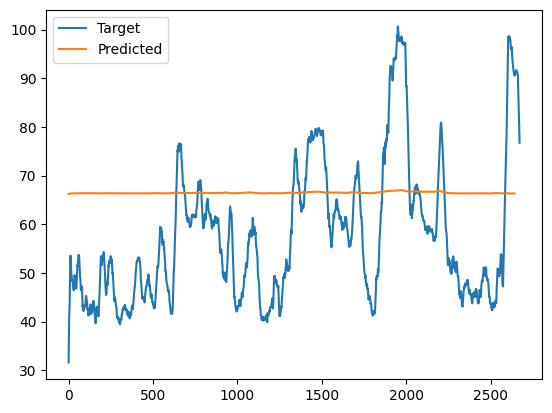

In [ ]:
#Train set
series_to_plot = a['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
smoothed_a_results = smooth(a_results,31)
plt.plot(smoothed_a_results,label = 'Predicted')
plt.legend()
plt.show()

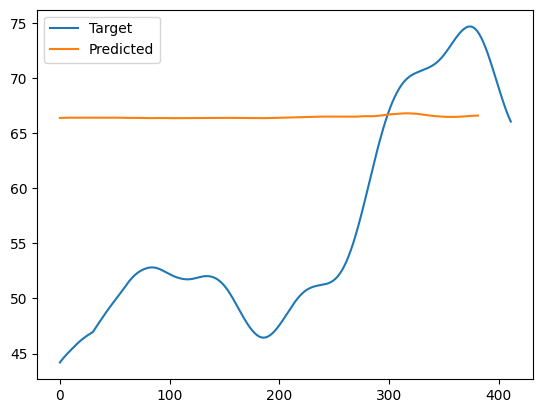

In [ ]:
#Test 1
#smooth the data
Test1['watt'] = Test1['watt'].rolling(window=31, min_periods=1).mean()
series_to_plot = Test1['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
smoothed_test1_results = smooth(Test1_results,31)
plt.plot(smoothed_test1_results,label = 'Predicted')
plt.legend()
plt.show()

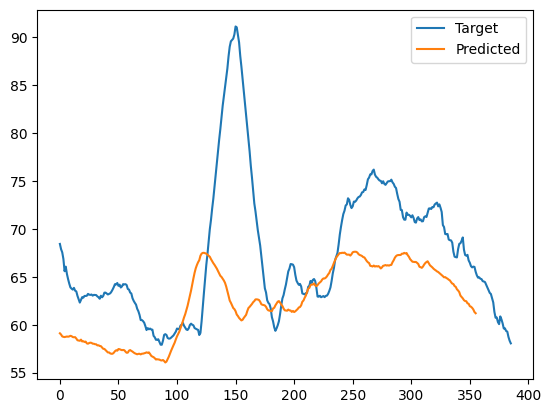

In [ ]:
#Test 2
#smooth the data
Test2['watt'] = Test2['watt'].rolling(window=31, min_periods=1).mean()
series_to_plot = Test2['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
smoothed_test2_results = smooth(Test2_results, 31)
plt.plot(smoothed_test2_results,label = 'Predicted')
plt.legend()
plt.show()

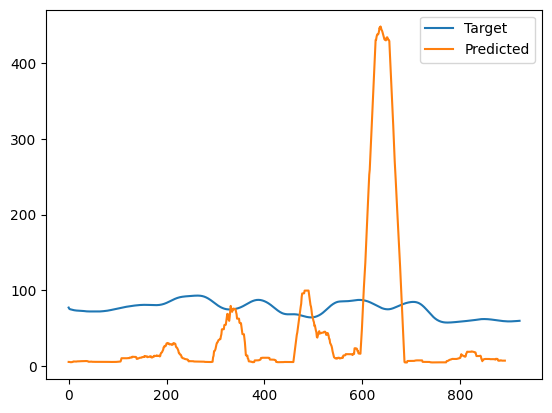

In [ ]:
#Test 3
#smooth the data
Test3['watt'] = Test3['watt'].rolling(window=31, min_periods=1).mean()
series_to_plot = Test3['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
smoothed_test3_results = smooth(Test3_results, 31)
plt.plot(smoothed_test3_results,label = 'Predicted')
plt.legend()
plt.show()

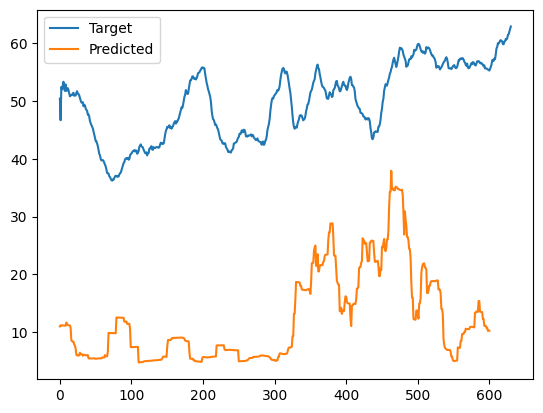

In [ ]:
#Test 4
#smooth the data
Test4['watt'] = Test4['watt'].rolling(window=31, min_periods=1).mean()
series_to_plot = Test4['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
smoothed_test4_results = smooth(Test4_results, 31)
plt.plot(smoothed_test4_results,label = 'Predicted')
plt.legend()
plt.show()

# Finding residuals


In [ ]:
residual_1 = Train_data_df['watt']-results
residuals_train = pd.Series(residuals_train, name = 'matlab_result')
# Assuming residual1 is already calculated and available
residual_1.plot(kind='bar',color='blue',label = 'machine_learning')
residuals_train.plot(kind='bar',color='orange',label = 'matlab_results')


plt.xticks([])
plt.legend()
# Adding labels and title for clarity
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of Predicted Values')

# Display the plot
plt.show()

In [ ]:
series_to_plot = Test_data_df['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
plt.plot(validation_results,label = 'Predicted')
plt.legend()
plt.show()

In [ ]:
residual_2 = Test_data_df['watt']-validation_results
residuals_test = pd.Series(residuals_test, name = 'matlab_result')
# Assuming residual1 is already calculated and available
residual_2.plot(kind='bar',color='blue',label = 'machine_learning')
residuals_test.plot(kind='bar',color='orange',label = 'matlab_results')


plt.xticks([])
plt.legend()
# Adding labels and title for clarity
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of Predicted Values')

# Display the plot
plt.show()

# The following is verifying result from the original dataset

In [ ]:
Real_06_df = pd.read_csv('3_12_15_06.csv')
Real_07_df = pd.read_csv('3_11_15_07.csv')

In [ ]:
CPU_usage_06 = Real_06_df['Core Usage (avg) [%]']
GPU_usage_06 = Real_06_df['GPU Utilization [%]']
total_06 = CPU_usage_06 + GPU_usage_06
residuals_06 = Residuals_from_matlab(total_06, Real_06_df['watt'])

In [ ]:
CPU_usage_07 = Real_07_df['Core Usage (avg) [%]']
GPU_usage_07 = Real_07_df['GPU Utilization [%]']
total_07 = CPU_usage_07 + GPU_usage_07
residuals_07 = Residuals_from_matlab(total_07, Real_07_df['watt'])

In [ ]:
#verifying result
results2 = []
X2 = scalar(Real_06_df[Train_feature_list])
for i in range(X2.shape[0]):
  n = X2[i].reshape(-1,1).T
  result = model1.predict(n,verbose=0)
  results2.append(result.squeeze())

In [ ]:
#verifying result
results3 = []
X3 = scalar(Real_07_df[Train_feature_list])
for i in range(X3.shape[0]):
  n = X3[i].reshape(-1,1).T
  result = model1.predict(n,verbose=0)
  results3.append(result.squeeze())

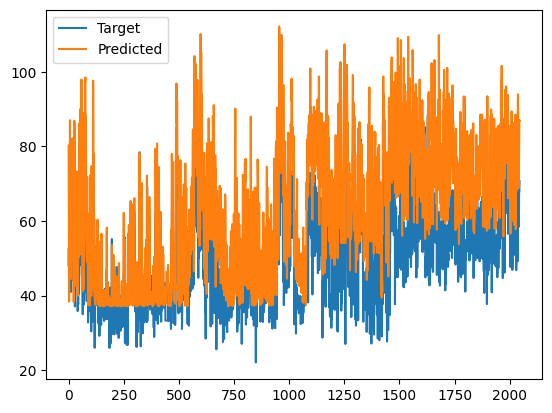

In [ ]:
series_to_plot = Real_06_df['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
plt.plot(results2,label = 'Predicted')
plt.legend()
plt.show()

In [ ]:
residual_3 = Real_06_df['watt']-results2
residuals_06 = pd.Series(residuals_06, name = 'matlab_result')
# Assuming residual1 is already calculated and available
residual_3.plot(kind='bar',color='blue',label='Machine_learning_result')
residuals_06.plot(kind='bar',color='orange',label='matlab_result')
plt.xticks([])
plt.legend()
# Adding labels and title for clarity
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of Predicted Values')

# Display the plot
plt.show()

In [ ]:
series_to_plot = Real_07_df['watt']
series_to_plot.plot(kind='line',label = 'Target')  # you can change 'line' to 'bar', 'hist' etc.
plt.plot(results3,label = 'Predicted')
plt.legend()
plt.show()

In [ ]:
residual_4 = Real_07_df['watt']-results3
residuals_07 = pd.Series(residuals_07, name = 'matlab_result')
# Assuming residual1 is already calculated and available
residual_4.plot(kind='bar',color='blue',label='Machine_learning_result')
residuals_07.plot(kind='bar',color='orange',label='matlab_result')
plt.xticks([])
# Adding labels and title for clarity
plt.legend()
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residuals of Predicted Values')

# Display the plot
plt.show()